In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import mobilenet_v2

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Sequential, optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import random
import os

%matplotlib inline

In [2]:
# settings for reproducibility
seed = 57
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

is_use_gpu = True
if is_use_gpu:
    gpu_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    os.environ['TF_USE_CUDNN'] = '1'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

Define locations of the train and validation datasets:

<h3>Utility Functions</h3>

In [3]:
# Utility function for quick class name access
def get_class_name(generator, image_id):
    # Get the image class and map its index with the names of the classes
    image_label_id = np.argmax(generator[image_id][1][0])
    classes_list = list(generator.class_indices.keys())
    return classes_list

In [4]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [5]:
# Utility function for obtaining of the errors 
def obtain_errors(val_generator, predictions):
    # Get the filenames from the generator
    fnames = validation_generator.filenames

    # Get the ground truth from generator
    ground_truth = validation_generator.classes

    # Get the dictionary of classes
    label2index = validation_generator.class_indices

    # Obtain the list of the classes
    idx2label = list(label2index.keys())
    print("The list of classes: ", idx2label)

    # Get the class index
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("Number of errors = {}/{}".format(len(errors),validation_generator.samples))
    
    return idx2label, errors, fnames

In [6]:
# Utility function for visualization of the errors
def show_errors(idx2label, errors, predictions, fnames):
    # Show the errors
    for i in range(len(errors)):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

In [7]:
# obtained from https://deeplizard.com/learn/video/km7pxKy4UHU

def plot_confusion_matrix(cm, classes,
                        normalize,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def generate_spoofing_metrics(confusion_matrix_result):  
    TN, FP, FN, TP = confusion_matrix_result.ravel()
    APCER = FP / (TN + FP)
    BPCER = FN/(FN + TP)
    ACER = (APCER + BPCER) / 2
    print("APCER: "+str(APCER))
    print("BPCER: "+str(BPCER))
    print("ACER: "+str(ACER))

In [9]:
#Posiblemente sirva para 3 clases
#confusion_matrix_result = confusion_matrix(validation_generator.classes, y_pred)
#print(confusion_matrix_result)
#FP = confusion_matrix_result.sum(axis=0) - np.diag(confusion_matrix_result)  
#FN = confusion_matrix_result.sum(axis=1) - np.diag(confusion_matrix_result)
#TP = np.diag(confusion_matrix_result)
#TN = confusion_matrix_result.sum() - (FP + FN + TP)

#print(TN)

<h3>Experiment</h3>

Create the model setting ``include_top`` parameter to ``False`` in order to exclude the fully-connected layers at the top of the network.

In [21]:
# Init the VGG model 
mobile_netv2_conv = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in mobile_netv2_conv.layers[:-73]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in mobile_netv2_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(mobile_netv2_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
# importante para recibir probabilidades
model.add(Dense(2, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

print(len(mobile_netv2_conv.layers))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2f3171cca0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f2fb07ed3a0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2f318b57c0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2e986bd4c0> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f2e985c6460> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f2e985d0670> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2e985e6d60> False
<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f2ecc553580> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2f3ac8c100> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2e98587e20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2e98599460

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              64226304  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 66,486,338
Trainable params: 66,267,138
Non-trainable params: 219,200
_________________________________________________________________
155


<h3>2. Prepare the training and validation data</h3>

In [37]:
train_dir = './experimento3/dataset6040maslive/train'
validation_dir = './experimento3/dataset6040maslive/test'

image_size = 224

In [38]:
# Load the normalized images
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, brightness_range=[0.2,1.0], zoom_range=[0.5,1.0])
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 64
val_batchsize = 8

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3200 images belonging to 2 classes.
Found 2100 images belonging to 2 classes.


<h3>3. Visualizing the datasets</h3>

The shape of train images: (224, 224, 3)
The shape of validation images: (224, 224, 3)


Text(0.5, 1.0, "Validation class name: ['fake', 'live']")

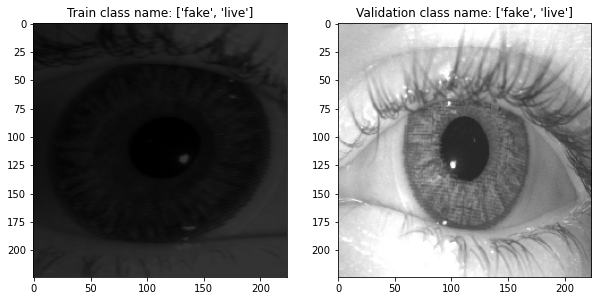

In [23]:
# Choose the image index for the visualization
image_id = 15

# Get the train image shape 
print("The shape of train images: {}".format(train_generator[image_id][0][0].shape))

# Get the validation image shape 
print("The shape of validation images: {}".format(validation_generator[image_id][0][0].shape))

# Visualize the train image example
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.imshow(train_generator[image_id][0][0])

# Show the train image class
plt.title("Train class name: {}".format(get_class_name(train_generator, image_id)))

# Visualize the validation image example
plt.subplot(122)
plt.imshow(validation_generator[image_id][0][0])

# show image class
plt.title("Validation class name: {}".format(get_class_name(validation_generator, image_id)))

<h3>4. Train the model</h3>

In [24]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,save_weights_only=False,verbose=1)

Epoch 1/100
47/46 [==============================] - 106s 2s/step - loss: 0.3153 - accuracy: 0.8698 - val_loss: 2.2595 - val_accuracy: 0.6655
Epoch 2/100
47/46 [==============================] - 39s 831ms/step - loss: 0.1072 - accuracy: 0.9624 - val_loss: 2.5037 - val_accuracy: 0.6701
Epoch 3/100
47/46 [==============================] - 38s 814ms/step - loss: 0.0850 - accuracy: 0.9708 - val_loss: 1.2954 - val_accuracy: 0.7200
Epoch 4/100
47/46 [==============================] - 38s 808ms/step - loss: 0.0428 - accuracy: 0.9834 - val_loss: 2.4373 - val_accuracy: 0.6757
Epoch 5/100
47/46 [==============================] - 38s 802ms/step - loss: 0.0538 - accuracy: 0.9800 - val_loss: 2.6937 - val_accuracy: 0.6712
Epoch 6/100
47/46 [==============================] - 38s 805ms/step - loss: 0.0404 - accuracy: 0.9861 - val_loss: 2.6310 - val_accuracy: 0.6757
Epoch 7/100
47/46 [==============================] - 38s 816ms/step - loss: 0.0322 - accuracy: 0.9895 - val_loss: 2.1415 - val_accuracy: 0

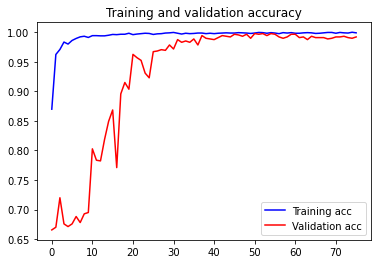

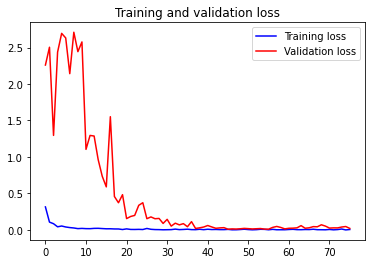

In [25]:
# Configure the model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=100,
      callbacks=[es_callback],
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

# Save the model
# model.save('all_freezed.h5')

# Run the function to illustrate accuracy and loss
visualize_results(history)

In [39]:
#save_dir  = './experimento1/resultados/entrenamiento2+live/1_rmsprop_weights.h5'
#model.save(save_dir)

from tensorflow.keras.models import load_model
model = load_model('./experimento3/resultados/experimento2/1_rmsprop_weights.h5')


<h3>Results</h3>

In [40]:
# Get the predictions from the model using the generator
predictions = model.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)

# Run the function to get the list of classes and errorattrs
idx2label, errors, fnames = obtain_errors(validation_generator, predictions)
 
# Run the function to illustrate the error cases

263/262 [==============================] - 28s 108ms/step
The list of classes:  ['fake', 'live']
Number of errors = 24/2100


Classification Report
              precision    recall  f1-score   support

        fake       1.00      0.98      0.99      1200
        live       0.98      0.99      0.99       900

    accuracy                           0.99      2100
   macro avg       0.99      0.99      0.99      2100
weighted avg       0.99      0.99      0.99      2100

Confusion matrix, without normalization
[[1181   19]
 [   5  895]]
APCER: 0.015833333333333335
BPCER: 0.005555555555555556
ACER: 0.010694444444444446


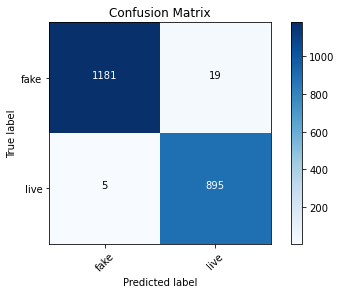

In [41]:
Y_pred = predictions
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_generator.classes, y_pred)
print('Classification Report')
target_names = validation_generator.class_indices.keys()
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))



#plot_confusion_matrix(cm=cm, classes=target_names, normalize=False, title='Confusion Matrix')
plot_confusion_matrix(cm=cm, classes=target_names, normalize=False, title='Confusion Matrix')
generate_spoofing_metrics(cm)

In [30]:
from sklearn.metrics import roc_curve, auc

pred_class = np.argmax(predictions[errors[0]])
pred_label = idx2label[pred_class]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(validation_generator.classes, y_pred)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)


In [31]:
#import numpy as np
#from sklearn import metrics

# valores reales en 1 y 0
#y = validation_generator.classes 

# resultados de la clasificacion(predicciones)
#scores = np.max(predictions, axis=-1)


#fpr, tpr, thresholds = metrics.roc_curve(y, scores)
#roc_auc = metrics.auc(fpr, tpr)

#plt.figure()
#lw = 2
#plt.plot(fpr, tpr, color='darkorange',
#lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic (ROC)')
#plt.legend(loc="lower right")
#plt.show()



In [15]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
print(idx2label)
print(predictions)
print("________________________________NEXT____________________________")

# Genuinos max(), Impostor min() -> Separar en archivos los max() que seran los genuinos y los min que seran los impostores
# a = np.max(predictions, axis=1)


#p.set_printoptions(formatter = {'all':lambda x: '{}\n'.format(x)})
#print(a)



['fake', 'live']
[[9.99930382e-01 2.10208002e-23]
 [1.00000000e+00 1.02478251e-27]
 [9.99987245e-01 1.47028514e-22]
 [9.99997854e-01 1.49989229e-27]
 [9.99990702e-01 8.95701460e-21]
 [9.99970913e-01 1.30282167e-18]
 [9.99953508e-01 7.67319038e-20]
 [9.89657700e-01 1.90787515e-19]
 [1.00000000e+00 3.46453381e-27]
 [9.99541759e-01 1.37264334e-22]
 [9.94951963e-01 7.70239486e-21]
 [1.00000000e+00 5.87937830e-28]
 [9.45779437e-04 3.05974453e-16]
 [9.99864936e-01 4.74471879e-25]
 [9.92828429e-01 1.86267871e-25]
 [2.07041409e-02 4.60616940e-16]
 [9.80176330e-01 2.21370273e-22]
 [5.27261955e-06 1.48597063e-12]
 [9.99971390e-01 6.04900444e-20]
 [3.63576233e-01 1.61012532e-20]
 [3.27957384e-02 4.68419921e-19]
 [7.25061670e-02 1.42878146e-17]
 [1.09705655e-03 6.44407405e-19]
 [8.91540229e-01 3.67922363e-19]
 [9.32323098e-01 6.26939873e-18]
 [9.90720272e-01 8.95453453e-18]
 [9.55636859e-01 1.34599028e-16]
 [9.99177516e-01 5.39635143e-21]
 [2.42834969e-04 4.93146919e-14]
 [4.50644475e-05 7.1981190

In [17]:
np.set_printoptions(formatter = {'all':lambda x: '{}\n'.format(x)})
print(predictions[:,1])

[2.1020800207251458e-23
 1.0247825085835872e-27
 1.4702851398204187e-22
 1.4998922850874133e-27
 8.957014595311789e-21
 1.3028216656850537e-18
 7.673190379627282e-20
 1.9078751515003951e-19
 3.4645338065428214e-27
 1.3726433448512724e-22
 7.70239486357052e-21
 5.879378304385759e-28
 3.0597445269049976e-16
 4.744718792321098e-25
 1.8626787072280658e-25
 4.606169402333622e-16
 2.2137027344086517e-22
 1.4859706347347679e-12
 6.04900444477322e-20
 1.6101253184690814e-20
 4.68419921480803e-19
 1.4287814620012092e-17
 6.444074047887701e-19
 3.67922362591103e-19
 6.269398731525184e-18
 8.954534533351944e-18
 1.3459902779797568e-16
 5.396351428988709e-21
 4.931469187001436e-14
 7.198119020051987e-15
 5.437336694952884e-25
 2.2593638716254674e-21
 4.387704838382593e-21
 6.806593235112684e-24
 1.3929498176627597e-17
 3.3282826247210296e-17
 4.370048894389847e-21
 8.937939842698058e-20
 5.371690735391931e-19
 5.2294738828684184e-18
 6.034731398874971e-22
 1.868968640352039e-27
 1.7420672538650706